In [1]:
import langchain as lc
import pandas as pd
import os
from langchain.prompts import PromptTemplate
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_openai import OpenAI
from langchain_openai import ChatOpenAI
import pandas as pd
from langchain_community.llms import LlamaCpp
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

def print_lines():
    print("-"*100)
    
STOP = "\s"

In [2]:
OT_CRASH = pd.read_excel("C:/Users/bobel/OneDrive - UCL/UCL/StatConsulting/CrashData.xlsx")

In [3]:
OT_CRASH_2023 = OT_CRASH["Désignation - Crash - Short"]

In [4]:
sample = OT_CRASH_2023.sample(n=40,random_state=69)
print(sample.iloc[:20,])

2551                Niveau bas suite fuite réseau
2914     CE ST Vaast (vieux):Alarme débit haut dé
10768                  Nettoyage suite inondation
24088                   Epine SP Défaut variateur
24883     controle et entretien de la cla val car
24067        Al Gofe : pression basse refoulement
2073      Maffle : Changement de group à distance
9698     Soldat la riviere: Modification prise en
26353      Basculement Soude et démarrage station
21436                NETTOYAGE ARMOIRE ASPIRATEUR
2096     NEUFCHATEAU CALVAIRE B SP: contrôle câbl
21994    Gestion des alarmes des stations d'Ecaus
423      Montignie : défaut générale telegestion,
712      SP Seneffe - placement groupe electrogèn
17843                           ouverture armoire
23530          Ormeignies CE - coupure de courant
8081     Placement/Remplacement installation BEAU
17011                              Passage caméra
24439             defaut com verification pompage
22080    Remplacement courroie cassée du compress


La description est bien souvent assez différente en fonction de l'opérateur
mais je peux observer quelques similitudes.
- L'opérateur indique souvent la localité dajà présente dans le dataset 
- On revoit souvent les mots vérification, problème, ajustements, ... Qui nous donnent un semblant de catégorie ? 
- Beaucoup d'abbréviations : Un dictionnaire des abbréviations courantes serait très utile.
- Beaucoup de déscriptions longues NA en 2023...

In [3]:
from langchain.globals import set_llm_cache
from langchain.cache import InMemoryCache
os.environ["OPENAI_API_KEY"] = "yourKey"
llm = ChatOpenAI()
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
set_llm_cache(InMemoryCache())

In [6]:
sample.iloc[11]

"Gestion des alarmes des stations d'Ecaus"

In [20]:
from datetime import date
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain.output_parsers.openai_functions import PydanticOutputFunctionsParser
from  langchain_core.utils.function_calling import convert_pydantic_to_openai_function
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate
import json


prompt_template = """
Vous êtes un assistant utile dont la tâche est d'analyser et d'extraire des informations à partir de rapports opérationnels détaillés concernant divers Incidents au sein d'une entreprise de gestion d'eau et de stations d'épurations. 
Votre objectif est d'extraire le type d'incident, en utilisant le rapport fournit. 
L'information extraite doit être présentée de manière organisée affin de mettre en place une future classification. L'incident doit être le plus clair possible et ne devrait pas dépasser 4 mots. 
Vous devez ignorer les données non pertinentes telles que les identifiants des rapports, les locations, les statuts mobiles, et les noms d'utilisateurs.
Chaque fois que l'incident n'est pas clair dans le rapport opérationnel vous devez simplement renvoyer l'information : DETAILS MANQUANTS.
Exemple : 

1. Rapport : 'Niveau bas suite fuite réseau', Incident : 'Fuite réseau'
2. Rapport : 'CE ST Vaast (vieux):Alarme débit haut dé', Incident : 'Haut débit'
3. Rapport : 'ESPINETTE DEFAUT DBM', Incident : 'Defaut DBM'
4. Rapport : 'Manoeuvres pour fuite 4 cuves', Incident : 'Fuite cuve'
5. Rapport : 'Epine SP Défaut variateur', Incident : 'Défaut Variateur'
6. Rapport : 'Controle et entretien de la cla val car', Incident : 'Entretien'
7. Rapport : 'Al Gofe : pression basse refoulement', Incident : 'Pression basse pompe'
8. Rapport : 'Intervention Process', Incident : 'DETAILS MANQUANTS'
9. Rapport : 'Maffle : Changement de group à distance', Incident : 'DETAILS MANQUANTS'
10. Rapport : 'NEUFCHATEAU CALVAIRE B SP: contrôle câbl', Incident : 'Contrôle cable'
11. Rapport : 'Gestion des alarmes des stations d'Ecaus', Incident : 'Gestion alarmes'
"""
prompt = ChatPromptTemplate.from_messages([
    ("system", prompt_template),
    ("user", "{input}")
])

parser = JsonOutputFunctionsParser()

class CrashMessage(BaseModel):
    Incident : str = Field(...,description="Une description la plus concise possible de l'incident si ce dernier est présente dans le rapport, 3 ou 4 mots maximum. Si il n'y a pas d'incident remplacer par : DETAILS MANQUANTS")
    
openai_functions = [convert_pydantic_to_openai_function(CrashMessage)]

parser = PydanticOutputFunctionsParser(pydantic_schema=CrashMessage)

chain = prompt | llm.bind(functions=openai_functions) | parser

print(sample.iloc[16])
chain.invoke({"input": sample.iloc[16]})

Placement/Remplacement installation BEAU


CrashMessage(Incident='Remplacement installation')

In [21]:
sample = OT_CRASH_2023.sample(n=10,random_state=69)
for i in range(0, 10):  
    print(sample.iloc[i]) 
    print(chain.invoke({"input": sample.iloc[i]}))
    print_lines()

Niveau bas suite fuite réseau
Incident='Fuite réseau'
----------------------------------------------------------------------------------------------------
CE ST Vaast (vieux):Alarme débit haut dé
Incident='Haut débit'
----------------------------------------------------------------------------------------------------
Nettoyage suite inondation
Incident='Inondation'
----------------------------------------------------------------------------------------------------
Epine SP Défaut variateur
Incident='Défaut variateur'
----------------------------------------------------------------------------------------------------
controle et entretien de la cla val car
Incident='Entretien'
----------------------------------------------------------------------------------------------------
Al Gofe : pression basse refoulement
Incident='Pression basse refoulement'
----------------------------------------------------------------------------------------------------
Maffle : Changement de group à distanc

OutputParserException: Could not parse function call: 'function_call'

J'utilise le TF-IDF pour faire des embeddings sur les 50 incidents simplifiés

In [23]:
def preprocess_emails(sample, chain):
    processed_incidents = []
    for incident in sample:
        try:
            processed_incident = chain.invoke({"input": incident})
            processed_incident = processed_incident.dict()["Incident"]
        except :
            processed_incident = "DETAILS MANQUANTS"
        processed_incidents.append(processed_incident)
    return processed_incidents

processed_incidents = preprocess_emails(OT_CRASH_2023.iloc[0:1000, ], chain)

In [24]:
processed_incidents[1:5]

['Remplissage sel', 'Contrôle chlore', 'Fuite évier', 'Remplissage immergé']

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import openai

client = openai.OpenAI()

# Step 1: Obtain embeddings from OpenAI for each incident
def get_openai_embeddings(texts):
    embeddings = []
    for text in texts:
        response = client.embeddings.create(
            model="text-embedding-ada-002",
            input=text,
            encoding_format="float"
        )
        embeddings.append(response.data[0].embedding)
    return np.array(embeddings)

In [30]:
X = get_openai_embeddings(processed_incidents)

c:\Users\bobel\miniconda3\envs\conda_DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\bobel\miniconda3\envs\conda_DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\bobel\AppData\Local\Temp\ipykernel_9964\2852736962.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Get a colormap from matplotlib (this one has 20 distinct colors)


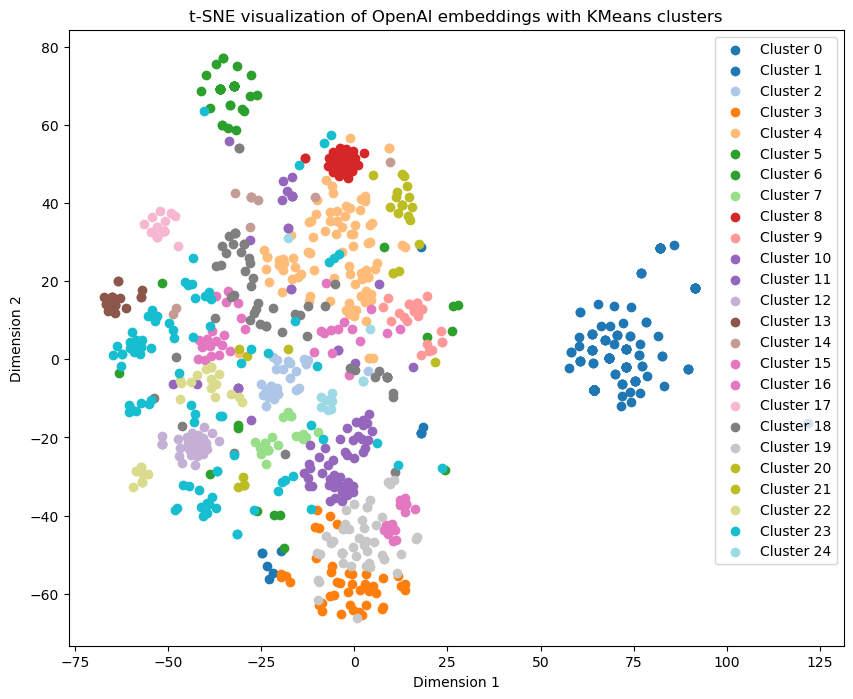

In [90]:
from matplotlib.cm import get_cmap

# Perform KMeans clustering
kmeans = KMeans(n_clusters=25, random_state=0)
clusters = kmeans.fit_predict(X)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

n_clusters = len(np.unique(clusters))  # Determine the number of unique clusters
cmap = get_cmap('tab20')  # Get a colormap from matplotlib (this one has 20 distinct colors)

plt.figure(figsize=(10, 8))

for i in range(n_clusters):
    # Normalize color index within the colormap's range
    color = cmap(float(i) / n_clusters)
    # Plot each cluster using its color
    plt.scatter(X_tsne[clusters == i, 0], X_tsne[clusters == i, 1], color=color, label=f'Cluster {i}')

plt.title('t-SNE visualization of OpenAI embeddings with KMeans clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [51]:
df_clusters = pd.DataFrame({
    'Text': processed_incidents,
    'Cluster': clusters
})

examples_per_cluster = df_clusters.groupby('Cluster').apply(lambda x: x.iloc[4])

# Display the example for each cluster
print(examples_per_cluster)

def display_cluster_examples(cluster_id, df_clusters, num_examples=10):
    """
    Display `num_examples` examples from a specified cluster in the DataFrame `df_clusters`.

    Parameters:
    - cluster_id: The ID of the cluster for which examples should be displayed.
    - df_clusters: The DataFrame containing the text data and their corresponding cluster labels.
    - num_examples: The number of examples to display (default is 10).
    """
    # Filter the DataFrame for the specified cluster
    cluster_examples = df_clusters[df_clusters['Cluster'] == cluster_id]
    
    # Select the first `num_examples` entries
    examples = cluster_examples.head(num_examples)
    
    # Display the examples
    for i, row in examples.iterrows():
        print(f"Example {i+1}: {row['Text']}\n")

                             Text  Cluster
Cluster                                   
0                      Reset TBOX        0
1               DETAILS MANQUANTS        1
2                Reparation fuite        2
3           Defaut câble téléphon        3
4                 Contrôle chlore        4
5                      Niveau bas        5
6                    Variateur HS        6
7                    Manque d'eau        7
8           Contrôle installation        8
9                     Haut chlore        9
10       Reparation pompe doseuse       10
11                Contrôle niveau       11
12                Coupure courant       12
13                   Entretien UV       13
14               Telegestion coup       14
15            Remplacement voyant       15
16          Non conformité chlore       16
17                 Lavage filtres       17
18                   Niveau cuves       18
19            Défaut installation       19
20                Surconsommation       20
21         

In [97]:
display_cluster_examples(12, df_clusters)

Example 22: Coupure courant

Example 27: Coupure ORES

Example 72: Coupure courant

Example 73: Coupure courant

Example 74: Coupure courant

Example 95: Coupure courant

Example 99: Coupure eau

Example 155: Coupure courant

Example 157: Coupure BT

Example 164: Coupure courant



In [93]:
df_clusters.to_feather('C:/Users/bobel/OneDrive - UCL/UCL/StatConsulting/clustersV1.feather')
np.save('C:/Users/bobel/OneDrive - UCL/UCL/StatConsulting/embeddingsV1.npy', X)